In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

data = pd.read_csv("Assignment_dataset.csv")


In [2]:
# Exploratory Data Analysis

# Quick look at the dataset
print(data.head())
print("\nShape of the dataset:", data.shape)
print("\nData types of each column:")
print(data.dtypes)
print("\nMissing values in each column:")
print(data.isnull().sum())


  ASSIGNED_SUBJECT  NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE  \
0       Humanities                     61             55             69   
1             STEM                     59             56             60   
2             STEM                     61             55             59   
3             STEM                     76             86             71   
4       Humanities                     69             52             66   

   MATH_SCORE  SOCIAL_SCIENCE_SCORE SCHOOL_CALENDAR  PUBLIC_SCHOOL  \
0          68                    68               A           True   
1          48                    53               A           True   
2          54                    57               A           True   
3          84                    75               A          False   
4          61                    68               A           True   

   BILINGUAL_SCHOOL GENDER PARENTS_EDUCATION FAMILY_INCOME_LEVEL  \
0             False      M           Primary                

In [3]:
# Summary Statistics:
print("\nSummary statistics for numerical columns:")
print(data.describe())


Summary statistics for numerical columns:
       NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE    MATH_SCORE  \
count           63587.000000   63587.000000   63587.000000  63587.000000   
mean               62.992247      64.323887      63.124617     64.311840   
std                 8.023284      11.870841       7.535490      9.532562   
min                27.000000      26.000000      28.000000     24.000000   
25%                58.000000      56.000000      58.000000     58.000000   
50%                63.000000      63.000000      63.000000     64.000000   
75%                68.000000      73.000000      68.000000     70.000000   
max               100.000000     100.000000     100.000000    100.000000   

       SOCIAL_SCIENCE_SCORE  
count          63587.000000  
mean              62.896897  
std                8.308691  
min               23.000000  
25%               57.000000  
50%               63.000000  
75%               68.000000  
max              100.000000  


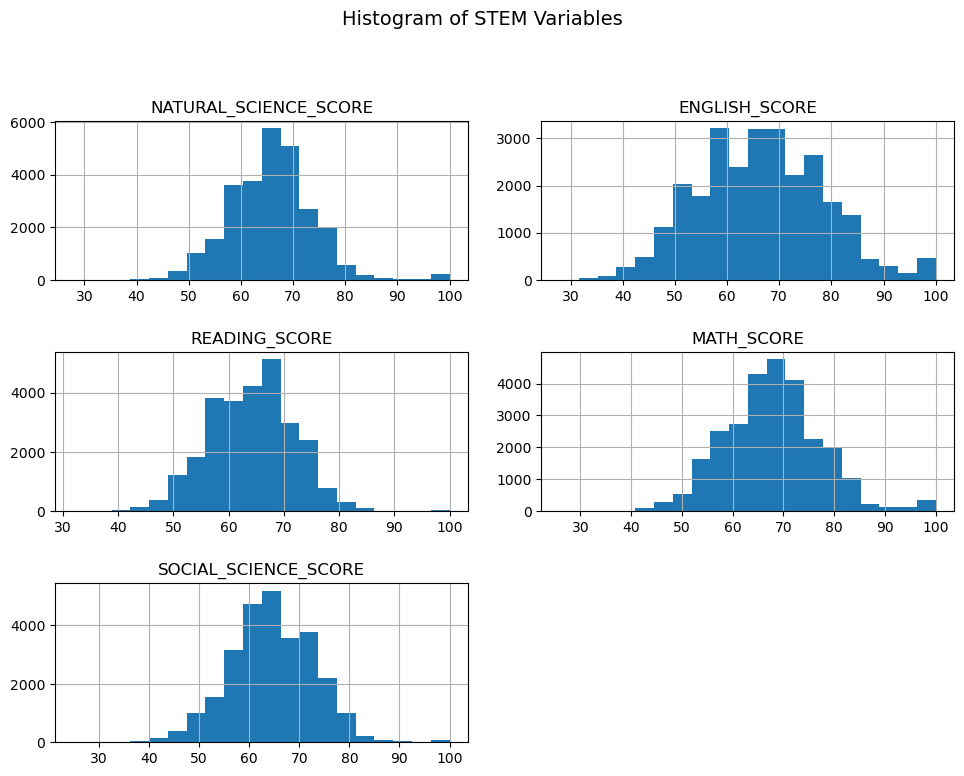

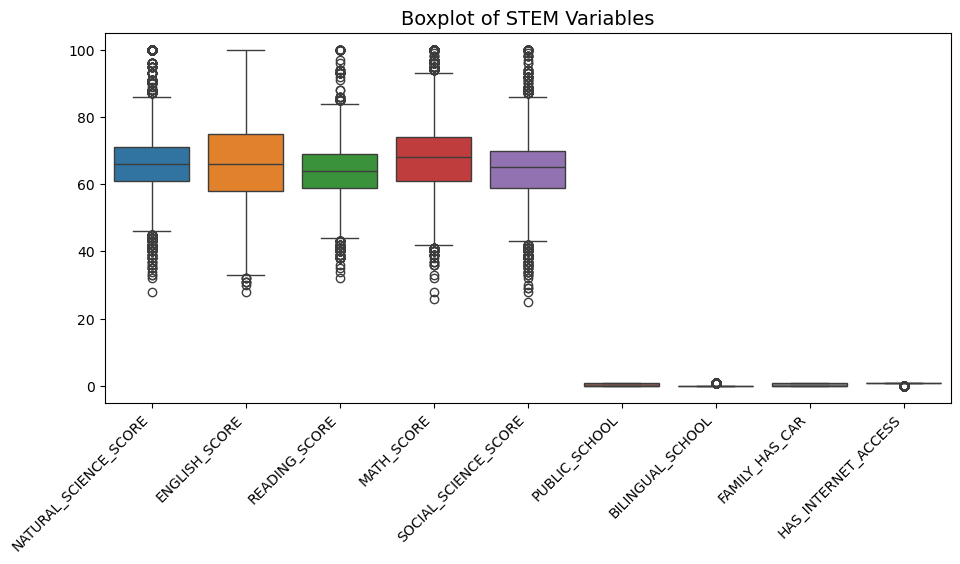

In [4]:
# Visual Exploratory Data Analysis for STEM:
stem_data = data[data["ASSIGNED_SUBJECT"] == "STEM"]
fig = stem_data.hist(figsize=(10, 8), bins=20) 
plt.suptitle('Histogram of STEM Variables', fontsize=14)


plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.96])  
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=stem_data)

plt.title('Boxplot of STEM Variables', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout(pad=2.0)
plt.show()

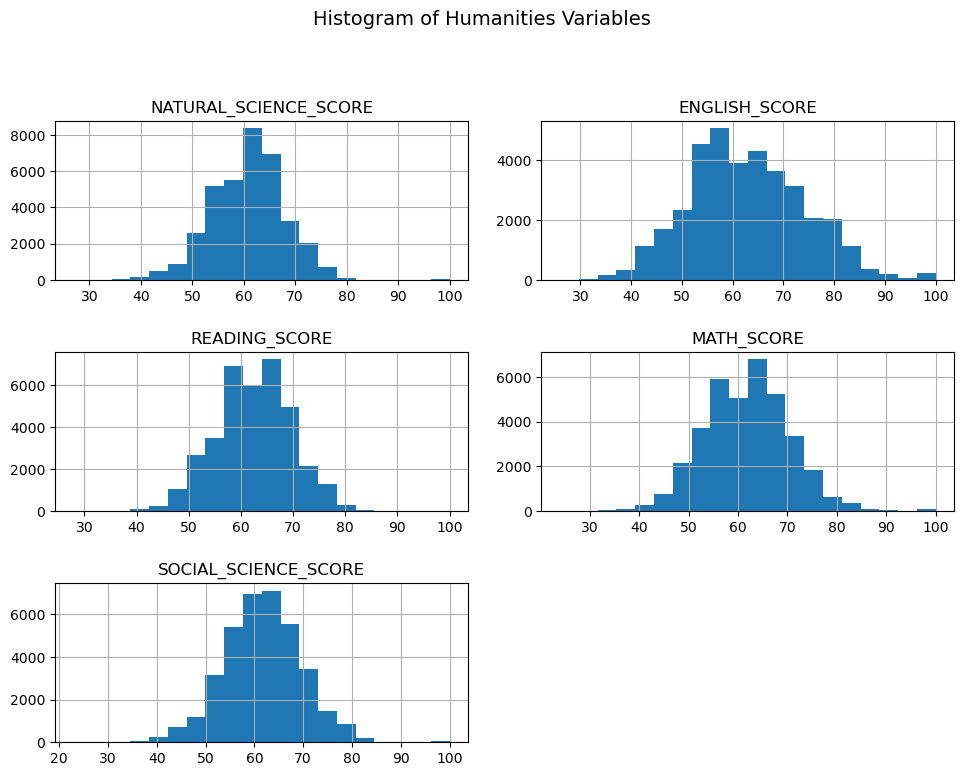

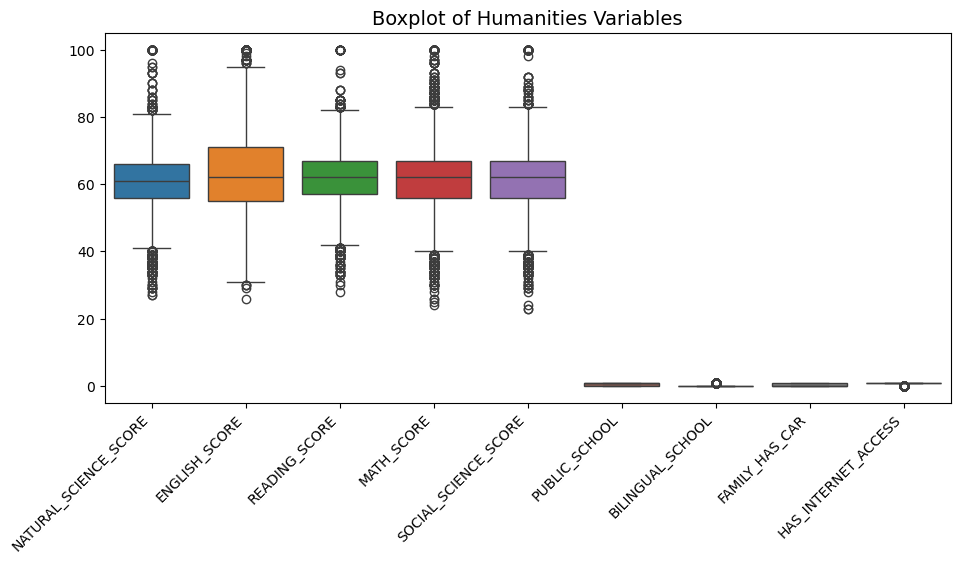

In [5]:
# Visual Exploratory Data Analysis for HUMANITIES:
human_data = data[data["ASSIGNED_SUBJECT"] == "Humanities"]
fig = human_data.hist(figsize=(10, 8), bins=20) 
plt.suptitle('Histogram of Humanities Variables', fontsize=14)


plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.96])  
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=human_data)

plt.title('Boxplot of Humanities Variables', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout(pad=2.0)
plt.show()

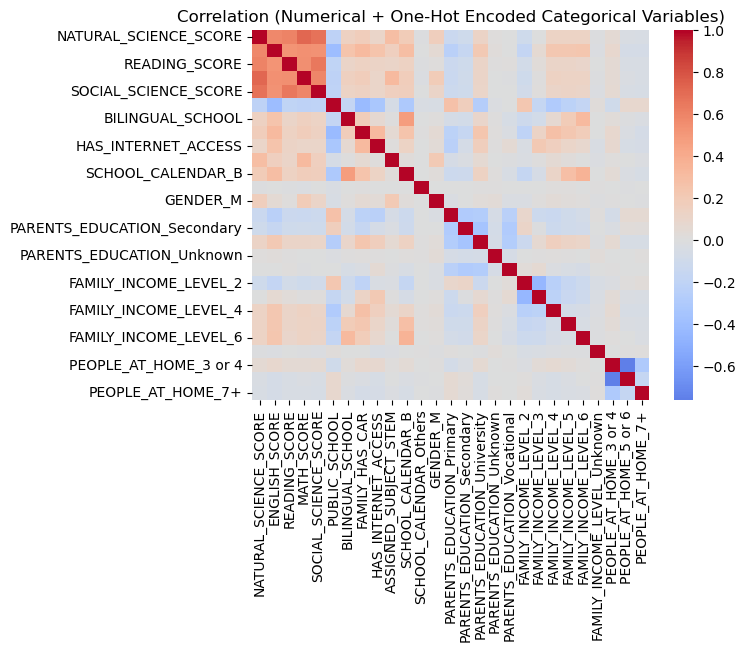

In [6]:
# Correlation analysis

#Firstly we need to use One-hot enconding on categorical data

encoded_data = pd.get_dummies(data, drop_first=True)

#Plot the heatmap
sns.heatmap(encoded_data.corr(), cmap="coolwarm", center=0)
plt.title("Correlation (Numerical + One-Hot Encoded Categorical Variables)")
plt.show()

In [7]:
print(encoded_data.tail())
print("\nShape of the dataset:", encoded_data.shape)
print("\nData types of each column:")
print(encoded_data.dtypes)
print("\nMissing values in each column:")
print(encoded_data.isnull().sum())

       NATURAL_SCIENCE_SCORE  ENGLISH_SCORE  READING_SCORE  MATH_SCORE  \
63582                     56             58             62          60   
63583                     53             57             59          60   
63584                     39             51             49          46   
63585                     56             54             67          62   
63586                     53             47             47          51   

       SOCIAL_SCIENCE_SCORE  PUBLIC_SCHOOL  BILINGUAL_SCHOOL  FAMILY_HAS_CAR  \
63582                    53           True             False            True   
63583                    45          False             False            True   
63584                    55           True             False            True   
63585                    66           True             False           False   
63586                    43           True             False           False   

       HAS_INTERNET_ACCESS  ASSIGNED_SUBJECT_STEM  ...  \
63582           

In [8]:
#Splitting the data
X = data.drop("ASSIGNED_SUBJECT", axis=1)
y = data["ASSIGNED_SUBJECT"]

X_dum = pd.get_dummies(X, drop_first=True)
y_dum = pd.get_dummies(y, drop_first=True)

# Divide the data for 20% test set first



X_temp, X_test, y_temp, y_test = train_test_split(X_dum, y_dum, test_size=0.2, random_state=42)

# Divide the other 80% data into 20% validation and the rest as training set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [9]:
# Crossvalidation

random_state = 42
# Define the hyperparameter grid


param_grid_random = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}



In [10]:
#Cross validation on Randomforest model

n_repeats = 3  # Number of repetitions for train/test splits
test_size = 0.3  # Proportion of data to be used as the test set
nested_cv_scores = []

# Variable to store the best overall model and best score across all outer splits
best_overall_model = None
best_overall_score = -np.inf

#Outer loop:StratifiedShuffleSplit
outer_cv = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size, random_state=random_state)

# Inner loop：StratifiedKFold 
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Pipeline for randomforest
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
])


# Outer loop
for train_idx, test_idx in outer_cv.split(X_dum, y_dum):
    X_train, X_test = X_dum.iloc[train_idx], X_dum.iloc[test_idx]
    y_train, y_test = y_dum.iloc[train_idx], y_dum.iloc[test_idx]

    # Gridsearch
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid_random,
        cv=inner_cv,
        scoring='f1',   # Using F1 score for balancing
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Getting the best model
    best_model = grid_search.best_estimator_

    # Evaluate on the test set
    test_score = best_model.score(X_test, y_test)
    nested_cv_scores.append(test_score)

    # Update the best model
    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model

# summary of the scores
nested_cv_scores = np.array(nested_cv_scores)

print("Nested cross-validation F1 scores:", nested_cv_scores)
print("Mean F1-score:", nested_cv_scores.mean())
print("Best overall model:\n", best_overall_model)

# Convert nested_cv_scores to a NumPy array for easy handling
nested_cv_scores = np.array(nested_cv_scores)

print("Nested cross-validation scores:", nested_cv_scores)
print("Mean accuracy:", nested_cv_scores.mean())
print("Best overall model:", best_overall_model)


e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Nested cross-validation F1 scores: [0.66944488 0.6757876  0.67148923]
Mean F1-score: 0.6722405689224372
Best overall model:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])
Nested cross-validation scores: [0.66944488 0.6757876  0.67148923]
Mean accuracy: 0.6722405689224372
Best overall model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])


In [11]:

random_state = 42

# Hyperparameters Logistic Regression 
param_grid_logic = {
    'model__penalty': ['l1', 'l2'],             # L1 = Lasso, L2 = Ridge
    'model__C': [0.01, 0.1, 1, 10],             
    'model__solver': ['liblinear', 'saga'],     
}

# hyperparameters of the crossvalidation loop
n_repeats = 3
test_size = 0.3
nested_cv_scores = []

best_overall_model = None
best_overall_score = -np.inf

# Stratified outer loop
outer_cv = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size, random_state=random_state)
# Stratified inner loop（for GridSearchCV）
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# Pipeline：Scaling + Logistic Regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=500))
])

# Outerloop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_dum, y_dum), 1):
    X_train, X_test = X_dum.iloc[train_idx], X_dum.iloc[test_idx]
    y_train, y_test = y_dum.iloc[train_idx], y_dum.iloc[test_idx]

    # Gridsearch parameter adjusting
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid_logic,
        cv=inner_cv,
        scoring='f1',   # For unbalanced classification
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Evaluation on the outer loop
    y_pred = best_model.predict(X_test)
    test_score = f1_score(y_test, y_pred)
    nested_cv_scores.append(test_score)

    print(f"\n=== Outer Fold {fold} ===")
    print("Best params:", grid_search.best_params_)
    print("F1 score:", test_score)
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Updating the best model
    if test_score > best_overall_score:
        best_overall_score = test_score
        best_overall_model = best_model

nested_cv_scores = np.array(nested_cv_scores)

print("\n=== Final Summary ===")
print("Nested cross-validation F1 scores:", nested_cv_scores)
print("Mean F1-score:", nested_cv_scores.mean())
print("Best overall model:\n", best_overall_model)


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== Outer Fold 1 ===
Best params: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
F1 score: 0.6259148662099655
Classification report:
               precision    recall  f1-score   support

       False       0.72      0.67      0.70     10942
        True       0.60      0.66      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.66      0.66      0.66     19077
weighted avg       0.67      0.67      0.67     19077

Confusion matrix:
 [[7343 3599]
 [2790 5345]]


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== Outer Fold 2 ===
Best params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
F1 score: 0.6345012222092888
Classification report:
               precision    recall  f1-score   support

       False       0.73      0.67      0.70     10942
        True       0.60      0.67      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.67      0.67      0.67     19077
weighted avg       0.68      0.67      0.67     19077

Confusion matrix:
 [[7346 3596]
 [2684 5451]]


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== Outer Fold 3 ===
Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
F1 score: 0.6257711968975851
Classification report:
               precision    recall  f1-score   support

       False       0.72      0.67      0.70     10942
        True       0.60      0.65      0.63      8135

    accuracy                           0.67     19077
   macro avg       0.66      0.66      0.66     19077
weighted avg       0.67      0.67      0.67     19077

Confusion matrix:
 [[7383 3559]
 [2810 5325]]

=== Final Summary ===
Nested cross-validation F1 scores: [0.62591487 0.63450122 0.6257712 ]
Mean F1-score: 0.6287290951056131
Best overall model:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                                    random_state=42, solver='liblinear'))])



 Running random_state = 0


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 1


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 2


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 3


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 4


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 5


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 6


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 7


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 8


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Running random_state = 9


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
e:\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 mean difference
        acc_diff    f1_diff   auc_diff
count  10.000000  10.000000  10.000000
mean    0.004450  -0.004826   0.001546
std     0.002283   0.002472   0.001169
min     0.000708  -0.009254  -0.000901
25%     0.002870  -0.006174   0.000907
50%     0.004718  -0.004763   0.001715
75%     0.005681  -0.002779   0.002366
max     0.007863  -0.001715   0.002865

🔹 RandomForest performs better random_state:
   random_state     rf_f1     lr_f1   f1_diff
9             9  0.625257  0.626972 -0.001715
8             8  0.629047  0.631128 -0.002082
3             3  0.629838  0.632441 -0.002603
7             7  0.628602  0.631910 -0.003308
4             4  0.620652  0.625197 -0.004545

🔹 LogisticRegression performs better random_state:
   random_state     rf_f1     lr_f1   f1_diff
5             5  0.616712  0.625966 -0.009254
6             6  0.628674  0.636244 -0.007570
1             1  0.621196  0.627444 -0.006248
2             2  0.618493  0.624443 -0.005950
0             0  0.622007  

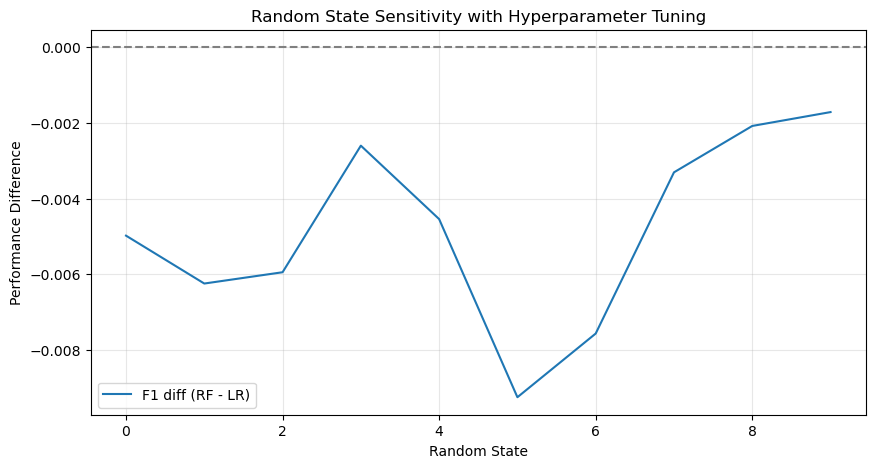

In [12]:

num_states = 10   # repetition
test_size = 0.2
cv = StratifiedKFold(n_splits=5, shuffle=True)
scoring = 'f1'    

# hyperparameters pipeline
rf_param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

lr_param_grid = {
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
}

# saving the result
results = []

for seed in range(num_states):
    print(f"\n Running random_state = {seed}")
    
    # data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X_dum, y_dum, test_size=test_size, random_state=seed, stratify=y_dum
    )
    
    # Logistic Regression + Scaling
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    lr_search = GridSearchCV(
        lr_pipe, lr_param_grid, cv=cv, scoring=scoring, n_jobs=-1
    )
    lr_search.fit(X_train, y_train)
    best_lr = lr_search.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    y_prob_lr = best_lr.predict_proba(X_test)[:, 1]
    
    # Random Forest
    rf_pipe = Pipeline([
        ('model', RandomForestClassifier(class_weight='balanced', random_state=seed))
    ])
    rf_search = GridSearchCV(
        rf_pipe, rf_param_grid, cv=cv, scoring=scoring, n_jobs=-1
    )
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
    
    # metrics
    metrics = {}
    for name, y_pred, y_prob in [
        ('rf', y_pred_rf, y_prob_rf),
        ('lr', y_pred_lr, y_prob_lr)
    ]:
        metrics[name+'_acc'] = accuracy_score(y_test, y_pred)
        metrics[name+'_f1'] = f1_score(y_test, y_pred)
        metrics[name+'_auc'] = roc_auc_score(y_test, y_prob)
    
    # saving the result
    results.append({
        'random_state': seed,
        'rf_best_params': rf_search.best_params_,
        'lr_best_params': lr_search.best_params_,
        **metrics,
        'acc_diff': metrics['rf_acc'] - metrics['lr_acc'],
        'f1_diff': metrics['rf_f1'] - metrics['lr_f1'],
        'auc_diff': metrics['rf_auc'] - metrics['lr_auc']
    })

# transform into DataFrame
results_df = pd.DataFrame(results)

# result
print("\n mean difference")
print(results_df[['acc_diff', 'f1_diff', 'auc_diff']].describe())

# find the seed that differs the most
print("\n🔹 RandomForest performs better random_state:")
print(results_df.sort_values('f1_diff', ascending=False).head(5)[['random_state', 'rf_f1', 'lr_f1', 'f1_diff']])

print("\n🔹 LogisticRegression performs better random_state:")
print(results_df.sort_values('f1_diff', ascending=True).head(5)[['random_state', 'rf_f1', 'lr_f1', 'f1_diff']])

# visualize
plt.figure(figsize=(10,5))
plt.plot(results_df['random_state'], results_df['f1_diff'], label='F1 diff (RF - LR)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Random State')
plt.ylabel('Performance Difference')
plt.title('Random State Sensitivity with Hyperparameter Tuning')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


C:\Users\Nemesis\AppData\Local\Temp\ipykernel_23632\1048355782.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1_Score', data=f1_long, palette='Set2')


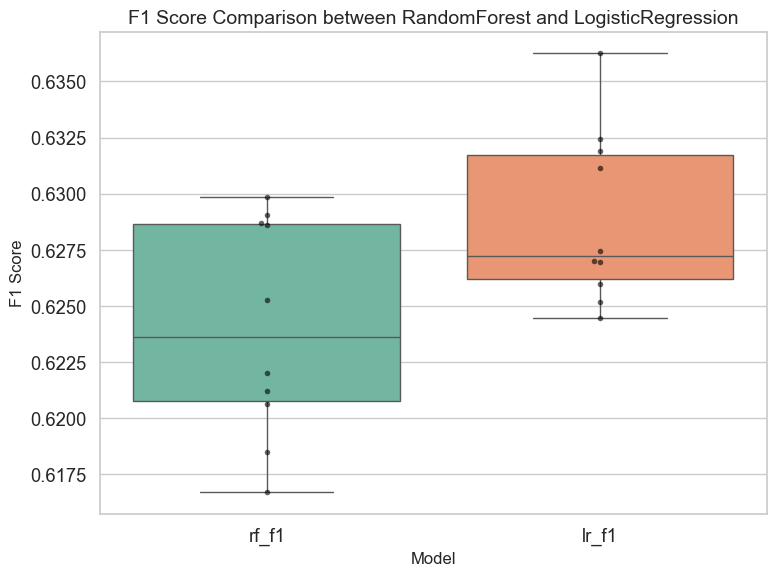

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


f1_data = results_df[['rf_f1', 'lr_f1']]

#transformation for usage of seaborn
f1_long = f1_data.melt(var_name='Model', value_name='F1_Score')


sns.set(style="whitegrid", font_scale=1.2)


plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='F1_Score', data=f1_long, palette='Set2')
sns.swarmplot(x='Model', y='F1_Score', data=f1_long, color='black', alpha=0.6, size=4)


plt.title('F1 Score Comparison between RandomForest and LogisticRegression', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.tight_layout()

plt.show()


In [14]:

rf_params_df = results_df[['rf_best_params', 'rf_f1']].copy()
rf_params_df['rf_best_params'] = rf_params_df['rf_best_params'].astype(str)
rf_summary = rf_params_df.groupby('rf_best_params')['rf_f1'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

print("RandomForest parameters（mean F1）:")
print(rf_summary.head(5))


lr_params_df = results_df[['lr_best_params', 'lr_f1']].copy()
lr_params_df['lr_best_params'] = lr_params_df['lr_best_params'].astype(str)
lr_summary = lr_params_df.groupby('lr_best_params')['lr_f1'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

print("\nLogisticRegression parameters(mean F1）:")
print(lr_summary.head(5))



RandomForest parameters（mean F1）:
                                                        mean       std  count
rf_best_params                                                               
{'model__max_depth': 10, 'model__min_samples_le...  0.628824  0.000314      2
{'model__max_depth': 10, 'model__min_samples_le...  0.625245  0.006495      2
{'model__max_depth': 10, 'model__min_samples_le...  0.625042  0.003744      3
{'model__max_depth': 10, 'model__min_samples_le...  0.622007       NaN      1
{'model__max_depth': 10, 'model__min_samples_le...  0.617603  0.001260      2

LogisticRegression parameters(mean F1）:
                                                        mean       std  count
lr_best_params                                                               
{'model__C': 0.1, 'model__penalty': 'l2', 'mode...  0.630249  0.004633      5
{'model__C': 0.01, 'model__penalty': 'l2', 'mod...  0.628938  0.004203      2
{'model__C': 1, 'model__penalty': 'l2', 'model_...  0.626538  0.001

Baseline performance:


e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6641767573517848
F1: 0.6276697759567605
AUC: 0.7227037582798219


array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER_M'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>],
       [<Axes: xlabel='GENDER_M'>, <Axes: xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>]], dtype=object)

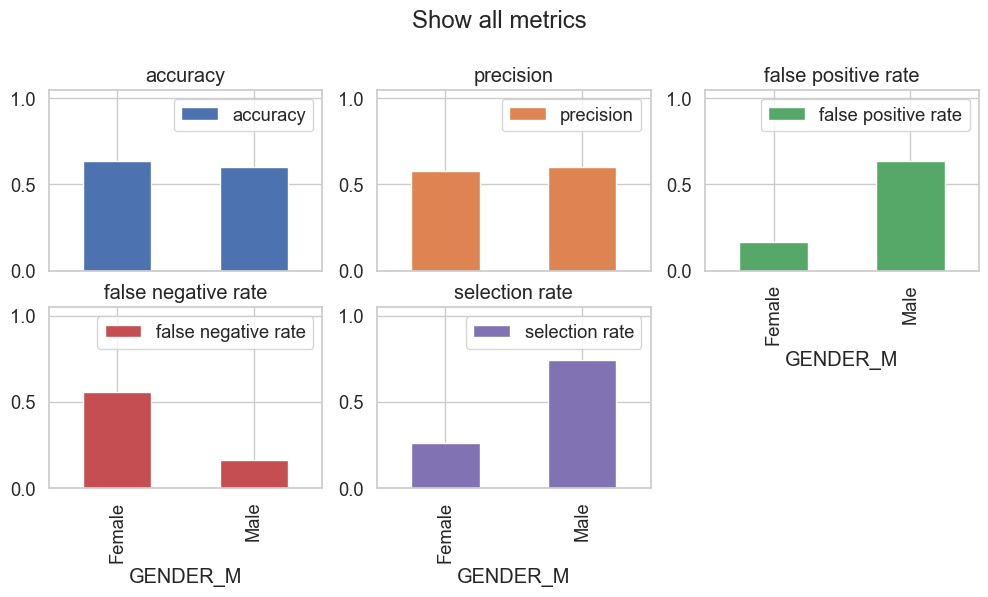

In [15]:
#Fairness evaluation

#Best logistic regression model

pipeline_logic = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(C =0.01, penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42))
])
pipeline_logic.fit(X_train, y_train)

y_pred = pipeline_logic.predict(X_test)
y_prob = pipeline_logic.predict_proba(X_test)[:, 1]

print("Baseline performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

sensitive_test = X_test['GENDER_M']
sensitive_test_named = sensitive_test.replace({False: 'Female', True: 'Male'})
#Plot


metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test_named
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=True,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)



e:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



CorrelationRemover model performance:
Accuracy: 0.6416103160874351
F1: 0.6048205306051674
AUC: 0.6893168575901616

CorrelationRemover model fairness metrics:
Demographic Parity Difference: 0.009362457392952939
Equalized Odds Difference: 0.07179372480342294


array([[<Axes: title={'center': 'accuracy'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'precision'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='GENDER_M'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='GENDER_M'>,
        <Axes: title={'center': 'selection rate'}, xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>],
       [<Axes: xlabel='GENDER_M'>, <Axes: xlabel='GENDER_M'>,
        <Axes: xlabel='GENDER_M'>]], dtype=object)

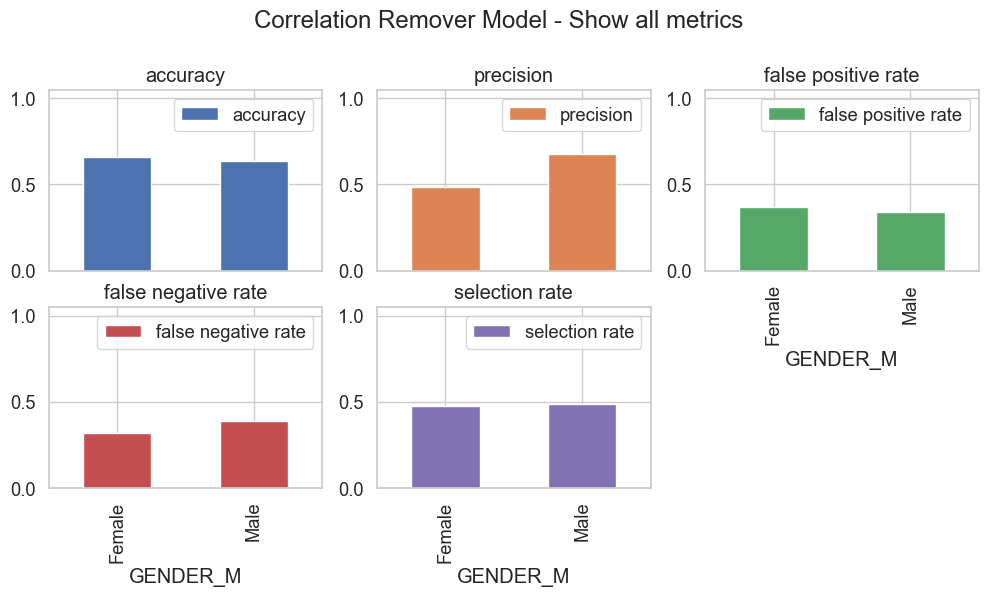

In [ ]:
from fairlearn.preprocessing import CorrelationRemover

# get gender_m from X_train
sensitive_feature = X_train['GENDER_M']

# convert to readable labels
sensitive_train = sensitive_feature.replace({False: 'Female', True: 'Male'})
sensitive_test_named = X_test['GENDER_M'].replace({False: 'Female', True: 'Male'})

# initialize correlation remover
corr_remover = CorrelationRemover(
    sensitive_feature_ids=['GENDER_M'], 
    alpha=1.0
) # alpha=1.0 fully removes linear correlation with sensitive feature

# fit on training set
corr_remover.fit(X_train)

# transform training and test sets
X_train_transformed = corr_remover.transform(X_train)
X_test_transformed = corr_remover.transform(X_test)

# model (no sample weights anymore)
reweighted_model = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(
        C=0.01,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

# train
reweighted_model.fit(X_train_transformed, y_train)

# predictions
y_pred_reweighted = reweighted_model.predict(X_test_transformed)
y_prob_reweighted = reweighted_model.predict_proba(X_test_transformed)[:, 1]

# compute metrics
reweighted_accuracy = accuracy_score(y_test, y_pred_reweighted)
reweighted_f1 = f1_score(y_test, y_pred_reweighted)
reweighted_auc = roc_auc_score(y_test, y_prob_reweighted)

print("\nCorrelationRemover model performance:")
print("Accuracy:", reweighted_accuracy)
print("F1:", reweighted_f1)
print("AUC:", reweighted_auc)

# fairness metrics
reweighted_metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test_named
)

dpd_reweighted = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test_named
)

eod_reweighted = equalized_odds_difference(
    y_true=y_test,
    y_pred=y_pred_reweighted,
    sensitive_features=sensitive_test_named
)

print("\nCorrelationRemover model fairness metrics:")
print("Demographic Parity Difference:", dpd_reweighted)
print("Equalized Odds Difference:", eod_reweighted)

# plot
reweighted_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=True,
    figsize=[12, 8],
    ylim=[0, 1.05],
    title="Correlation Remover Model - Show all metrics"
)
